In [1]:
import os
import numpy as np

import scipy.ndimage.morphology as morph

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from PIL import Image

to_pil = transforms.ToPILImage()
os.listdir('../test_r_unet/data/')

['test_output',
 'test_output(without_gru)',
 'test_output(gru_nan)',
 '__pycache__',
 'test',
 'labels',
 'images',
 'dataloader.py']

In [2]:
# arguments
timesteps = 3
batch_size = 4
num_epochs = 50
input_size = 128
num_classes = 2

gru_nan = True

transform = transforms.Compose([
                              transforms.Resize((128, 128), interpolation = 0),
#                               transforms.RandomHorizontalFlip(p=0.5),
#                               transforms.RandomVerticalFlip(p=0.5),
                              transforms.ToTensor()
                              ])

to_tensor = transforms.ToTensor()

# decive
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# way to the data folders
folder_data = "../test_r_unet/data/images"
folder_mask = "../test_r_unet/data/labels"
folder_test = "../test_r_unet/data/test"

file_names = sorted(os.listdir('../test_r_unet/data/images'))

In [4]:
def get_labels(object):
    label1 = (object==0).float()
    label2 = (label1==0).float()
    labels = torch.stack([label1, label2], dim=1)
    return labels

In [5]:
class MedData(Dataset):
    def __init__(self):
        super().__init__()
        self.time = timesteps
        self.folder_data = folder_data
        self.folder_mask = folder_mask
        self.file_names = file_names
        
    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_data + '/' + file_names[idx+i])).unsqueeze(0))
        gif_data = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            gif_list.append(get_labels(transform(Image.open(self.folder_mask + '/' + file_names[idx+i]))).unsqueeze(0))
        gif_mask = torch.stack(gif_list).squeeze(dim=2)
        #gif_mask = gif_mask[:,:,0,:,:,:]
        gif_list.clear()
        for i in range(self.time):
            img = Image.open(folder_mask + '/' + file_names[idx+i])
            img = img.resize((128, 128), resample=Image.NEAREST)
            gif_list.append(to_tensor(morph.distance_transform_edt(np.asarray(img)/255)).unsqueeze(0))
        gif_depth = torch.stack(gif_list)
        return gif_data, gif_mask, gif_depth
    
    def __len__(self):
        return len(self.file_names) - self.time + 1
    
    
class TestMedData(Dataset):
    def __init__(self):
        super().__init__
        self.time = timesteps
        self.folder_test = folder_test
        self.file_names = file_names
        
    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_test + '/' + file_names[idx+i])).unsqueeze(0))
        gif_test = torch.stack(gif_list)
        gif_list.clear()
        return gif_test
    
    def __len__(self):
        return len(self.file_names) - self.time + 1
        

In [6]:
dataset = MedData()
test_dataset = TestMedData()

train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         num_workers=2,
                         shuffle=False)

In [7]:
class GruCell(nn.Module):
    
    def __init__(self, channel):
        super(GruCell, self).__init__()
        self.conv_relu = nn.Sequential(nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1),
                                       nn.ELU(),
                                       nn.Dropout(p=0.2))
        
        self.conv_relu_2x = nn.Sequential(nn.Conv2d(in_channels=channel+channel, out_channels=channel, kernel_size=3, stride=1, padding=1),
                                          nn.ELU(),
                                          nn.Dropout(p=0.2))
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.conv_relu_2x(input)
        update_gate = self.sig((update_gate)) ### output after update gate
        reset_gate = self.conv_relu_2x(input)
        reset_gate = self.sig((reset_gate)) ### output after reset gate
        
        
        memory_gate_for_input = self.conv_relu(x)
        memory_gate_for_hidden = self.conv_relu(hidden)

        memory_content = memory_gate_for_input + (reset_gate * memory_gate_for_hidden) ### output for reset gate(affects how the reset gate do work)
        memory_content = self.relu(memory_content)

        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden

In [8]:
# create class Gru
class Gru(nn.Module):

    def __init__(self, channels_size, gru_input_size): # arg for gru layer
        super(Gru, self).__init__()
        self.batch_size = batch_size
        self.timesteps = timesteps
        self.channels_size = channels_size
        self.input_size = gru_input_size
        self.hidden_size = (self.batch_size, channels_size, gru_input_size, gru_input_size)
        
        self.gru_layer0 = GruCell(channels_size)
        self.init_hidden = torch.zeros(self.hidden_size).to(device)
        self.gru_nan = gru_nan


    def forward(self, x):
        x_cells = None
        x_list = []
        if self.gru_nan == False:
            try:
                x = x.reshape(batch_size, timesteps, self.channels_size, self.input_size, self.input_size)
                x = x.permute(1, 0, 2, 3, 4)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], self.init_hidden)
                        x_list.append(x_cells)
                    else:
                        x_i, hidden = self.gru_layer0(x[i], hidden)
                        x_list.append(x_i)
                x_cells = torch.stack(x_list)

             ##### FOR LAST BATCH
            except RuntimeError:
                x = x.reshape(1, timesteps, self.channels_size, self.input_size, self.input_size) #last batch is (15), but batch_size = 16, #arg.timesteps = 2 
                x = x.permute(1, 0, 2, 3, 4)
                hidden_zero = torch.zeros_like(x)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], hidden_zero[0])
                        x_list.append(x_cells)
                    else:
                        x_i, hidden = self.gru_layer0(x[i], hidden)
                        x_list.append(x_i)
                x_cells = torch.stack(x_list)
             #####
        elif self.gru_nan == True:
            try:
                x = x.reshape(batch_size, timesteps, self.channels_size, self.input_size, self.input_size)
                x = x.permute(1, 0, 2, 3, 4)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], self.init_hidden)
                        x_list.append(x_cells)
                    else:
                        x_i, hidden = self.gru_layer0(x[i], self.init_hidden)
                        x_list.append(x_i)
                x_cells = torch.stack(x_list)

             ##### FOR LAST BATCH
            except RuntimeError:
                x = x.reshape(1, timesteps, self.channels_size, self.input_size, self.input_size) #last batch is (15), but batch_size = 16, #arg.timesteps = 2 
                x = x.permute(1, 0, 2, 3, 4)
                hidden_zero = torch.zeros_like(x)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], hidden_zero[0])
                        x_list.append(x_cells)
                    else:
                        x_i, hidden = self.gru_layer0(x[i], hidden_zero[0])
                        x_list.append(x_i)
                x_cells = torch.stack(x_list)
             #####
        else:
            print('gru_nan can be only True or False')
            quit()
        x_cells = x_cells.reshape(-1, self.channels_size, self.input_size, self.input_size)

        return x_cells  

In [9]:
class Conv3x3Small(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Conv3x3Small, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_feat, out_feat,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ELU(),
                                   nn.Dropout(p=0.2))

        self.conv2 = nn.Sequential(nn.Conv2d(out_feat, out_feat,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ELU())

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs


class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Dropout(p=0.2)
        )

    def forward(self, x):
        return self.double_conv(x)

    
class Conv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Dropout(p=0.2)
        )

    def forward(self, x):
        return self.conv(x)


class UpConcat(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UpConcat, self).__init__()

        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # self.deconv = nn.ConvTranspose2d(in_feat, out_feat,
        #                                  kernel_size=3,
        #                                  stride=1,
        #                                  dilation=1)

        self.deconv = nn.ConvTranspose2d(in_feat,
                                         out_feat,
                                         kernel_size=2,
                                         stride=2)

    def forward(self, inputs, down_outputs):
        # TODO: Upsampling required after deconv?
        # outputs = self.up(inputs)
        outputs = self.deconv(inputs)
        out = torch.cat([down_outputs, outputs], 1)
        return out


class UpSample(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UpSample, self).__init__()

        self.up = nn.Upsample(scale_factor=2, mode='nearest')

        self.deconv = nn.ConvTranspose2d(in_feat,
                                         out_feat,
                                         kernel_size=2,
                                         stride=2)

    def forward(self, inputs, down_outputs):
        # TODO: Upsampling required after deconv?
        outputs = self.up(inputs)
        # outputs = self.deconv(inputs)
        out = torch.cat([outputs, down_outputs], 1)
        return out

In [10]:
class UNetSmall(nn.Module):
    def __init__(self, num_channels=1, num_classes=2):
        super(UNetSmall, self).__init__()
        num_feat = [32, 64, 128, 256]
        self.input_size = input_size

        self.down1 = nn.Sequential(DoubleConv(num_channels, num_feat[0]))

        self.down2 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Gru(num_feat[0], gru_input_size=64),
                                   Conv(num_feat[0], num_feat[1]))

        self.down3 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Gru(num_feat[1], gru_input_size=32),
                                   Conv(num_feat[1], num_feat[2]))

        self.bottom = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Gru(num_feat[2], gru_input_size=16),
                                   Conv(num_feat[2], num_feat[3]))

        self.up1 = UpSample(num_feat[3], num_feat[2])
        self.upconv1 = nn.Sequential(Conv3x3Small(num_feat[3] + num_feat[2], num_feat[2]),
                                     nn.BatchNorm2d(num_feat[2]))

        self.up2 = UpSample(num_feat[2], num_feat[1])
        self.upconv2 = nn.Sequential(Conv3x3Small(num_feat[2] + num_feat[1], num_feat[1]),
                                     nn.BatchNorm2d(num_feat[1]))

        self.up3 = UpSample(num_feat[1], num_feat[0])
        self.upconv3 = nn.Sequential(Conv3x3Small(num_feat[1] + num_feat[0], num_feat[0]),
                                     nn.BatchNorm2d(num_feat[0]))

        self.final = nn.Sequential(nn.Conv2d(num_feat[0], num_classes, kernel_size=1),
                                   nn.Sigmoid(),
                                   nn.Softmax()
                                   )

    def forward(self, inputs, return_features=False):
        inputs = inputs.reshape(-1, 1, self.input_size, self.input_size)
        # print(inputs.data.size())
        down1_feat = self.down1(inputs)
        # print(down1_feat.size())
        down2_feat = self.down2(down1_feat)
        # print(down2_feat.size())
        down3_feat = self.down3(down2_feat)
        # print(down3_feat.size())
        bottom_feat = self.bottom(down3_feat)

        # print(bottom_feat.size())
        up1_feat = self.up1(bottom_feat, down3_feat)
        # print(up1_feat.size())
        up1_feat = self.upconv1(up1_feat)
        # print(up1_feat.size())
        up2_feat = self.up2(up1_feat, down2_feat)
        # print(up2_feat.size())
        up2_feat = self.upconv2(up2_feat)
        # print(up2_feat.size())
        up3_feat = self.up3(up2_feat, down1_feat)
        # print(up3_feat.size())
        up3_feat = self.upconv3(up3_feat)
        # print(up3_feat.size())

        if return_features:
            outputs = up3_feat
        else:
            outputs = self.final(up3_feat)
        
        

        return outputs

In [11]:
class WithoutGruUNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=2):
        super(WithoutGruUNet, self).__init__()
        num_feat = [32, 64, 128, 256]
        self.input_size = input_size

        self.down1 = nn.Sequential(Conv3x3Small(num_channels, num_feat[0]))

        self.down2 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3Small(num_feat[0], num_feat[1]))

        self.down3 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3Small(num_feat[1], num_feat[2]))

        self.bottom = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                    Conv3x3Small(num_feat[2], num_feat[3])
                                   )

        self.up1 = UpSample(num_feat[3], num_feat[2])
        self.upconv1 = nn.Sequential(Conv3x3Small(num_feat[3] + num_feat[2], num_feat[2]),
                                     nn.BatchNorm2d(num_feat[2]))

        self.up2 = UpSample(num_feat[2], num_feat[1])
        self.upconv2 = nn.Sequential(Conv3x3Small(num_feat[2] + num_feat[1], num_feat[1]),
                                     nn.BatchNorm2d(num_feat[1]))

        self.up3 = UpSample(num_feat[1], num_feat[0])
        self.upconv3 = nn.Sequential(Conv3x3Small(num_feat[1] + num_feat[0], num_feat[0]),
                                     nn.BatchNorm2d(num_feat[0]))

        self.final = nn.Sequential(nn.Conv2d(num_feat[0], num_classes, kernel_size=1),
                                   nn.Sigmoid(),
                                   nn.Softmax()
                                   )

    def forward(self, inputs, return_features=False):
        inputs = inputs.reshape(-1, 1, self.input_size, self.input_size)
        # print(inputs.data.size())
        down1_feat = self.down1(inputs)
        # print(down1_feat.size())
        down2_feat = self.down2(down1_feat)
        # print(down2_feat.size())
        down3_feat = self.down3(down2_feat)
        # print(down3_feat.size())
        bottom_feat = self.bottom(down3_feat)

        # print(bottom_feat.size())
        up1_feat = self.up1(bottom_feat, down3_feat)
        # print(up1_feat.size())
        up1_feat = self.upconv1(up1_feat)
        # print(up1_feat.size())
        up2_feat = self.up2(up1_feat, down2_feat)
        # print(up2_feat.size())
        up2_feat = self.upconv2(up2_feat)
        # print(up2_feat.size())
        up3_feat = self.up3(up2_feat, down1_feat)
        # print(up3_feat.size())
        up3_feat = self.upconv3(up3_feat)
        # print(up3_feat.size())

        if return_features:
            outputs = up3_feat
        else:
            outputs = self.final(up3_feat)
        
        

        return outputs

In [12]:
model = WithoutGruUNet()
model = model.to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

def dice_loss(pred, target, depth, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    #print(pred.shape, target.shape, depth.shape)
    intersection = (pred * target * depth).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / ((pred*depth).sum(dim=2).sum(dim=2) + (target*depth).sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(prediction, target, depth, bce_weight=0.3):
    try:
        prediction = prediction.reshape(timesteps*batch_size, num_classes, input_size, input_size)
        target = target.reshape(timesteps*batch_size, num_classes, input_size, input_size)
        depth = depth.reshape(timesteps*batch_size, 1, input_size, input_size)
    except RuntimeError:
        prediction = prediction.reshape(timesteps*1, num_classes, input_size, input_size) # last_batch = 1
        target = target.reshape(timesteps*1, num_classes, input_size, input_size)
        depth = depth.reshape(timesteps*1, 1, input_size, input_size)
    bce = F.binary_cross_entropy_with_logits(prediction, target)
    prediction = F.sigmoid(prediction)
    dice = dice_loss(prediction, target, depth)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss # dice

def lossy(x, y, d):
    return (((x - y)**2).sum(dim=1)*d**2).sum()/(256**2)

In [14]:
def IoU(pred, target):
    tanh = nn.Tanh()
    pred = tanh(pred)
    pred = pred.contiguous() * (-1)
    target = target.contiguous() * (-1)  
    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (torch.abs(intersection))/(torch.abs(pred.sum(dim=2).sum(dim=2))+torch.abs(target.sum(dim=2).sum(dim=2))-torch.abs(intersection))
    return loss.mean()

In [15]:
for epoch in range(num_epochs):
    metric = 0
    print('epoch: ', epoch)
    for i, data in enumerate(train_loader):
        input, label, depth = data
        input = input.to(device)
        label = label.to(device)
        depth = depth.to(device)
        output = model(input)
        loss = calc_loss(output, label, depth)      
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        output1 = (output>0.3).float()
        metric_out = output1.reshape(-1, 2, 128, 128)
        metric_label = label.reshape(-1, 2, 128, 128)
        metric += IoU(metric_out, metric_label)
    print("IoU: ", metric.item() / i)

epoch:  0


/headless/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/headless/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


IoU:  0.48412787914276123
epoch:  1
IoU:  0.4596133629480998
epoch:  2
IoU:  0.45592498779296875
epoch:  3
IoU:  0.4618280331293742
epoch:  4
IoU:  0.4670989513397217
epoch:  5
IoU:  0.4733785390853882
epoch:  6
IoU:  0.4829169511795044
epoch:  7
IoU:  0.49129215876261395
epoch:  8
IoU:  0.5017092227935791
epoch:  9
IoU:  0.5103142261505127
epoch:  10
IoU:  0.5157569646835327
epoch:  11
IoU:  0.5254488388697306
epoch:  12
IoU:  0.5335179169972738
epoch:  13
IoU:  0.5395801464716593
epoch:  14
IoU:  0.5498296419779459
epoch:  15
IoU:  0.5598493814468384
epoch:  16
IoU:  0.567015528678894
epoch:  17
IoU:  0.5754068692525228
epoch:  18
IoU:  0.586158831914266
epoch:  19
IoU:  0.5903295675913492
epoch:  20
IoU:  0.6006296078364054
epoch:  21
IoU:  0.6073629856109619
epoch:  22
IoU:  0.6178117593129476
epoch:  23
IoU:  0.6258658568064371
epoch:  24
IoU:  0.6310453017552694
epoch:  25
IoU:  0.6375256379445394
epoch:  26
IoU:  0.6443480650583903
epoch:  27
IoU:  0.6522595882415771
epoch:  28


In [16]:
def showw(object):
    inp = object.reshape(-1, 1, 128, 128).cpu()
    return to_pil(inp[0])

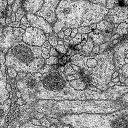

In [17]:
showw(input)

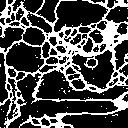

In [18]:
output1 = (output>0.3).float()
metric_out = output1.reshape(-1, 2, 128, 128)
showw(output1)

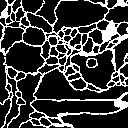

In [19]:
metric_label = label.reshape(-1, 2, 128, 128)
showw(label)

In [20]:
IoU(metric_out, metric_label)

tensor(0.6308, device='cuda:0')

In [21]:
list_inp = []
list_out = []
for i, data in enumerate(test_loader):
    input = data
    input = input.to(device)
    test_output = model(input)
    list_inp.append(input)
    list_out.append(test_output)

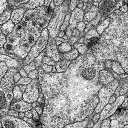

In [22]:
showw(list_inp[0][0])

In [23]:
showw(list_out[0][0])
list_out[0][0].shape

torch.Size([2, 128, 128])

In [24]:
from PIL import ImageSequence

In [25]:
index = 3 
for i in range(len(list_out)):
    test_out = showw(list_out[i][2][1])
    test_out.save("../test_r_unet/data/test_output(without_gru)/frame%d.png" % index)
    index += 1

In [26]:
list_out[0][0].shape

torch.Size([2, 128, 128])

In [27]:
print(output[0][1].shape, label.shape)

torch.Size([128, 128]) torch.Size([4, 3, 1, 2, 128, 128])
